In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from scipy.stats import zscore

In [2]:
np.random.seed(42)
set_backend("cupy")
plt.style.use("default")
sns.set_theme(style="whitegrid")

In [3]:
n_samples_train = 1000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_scalar = 0.0

In [4]:
alphas = np.logspace(-4, 4, 10)

generate random feature spaces

In [5]:
feature_spaces = [zscore(np.random.randn(n_samples_train + n_samples_test, dim)) for dim in d_list]

<Axes: ylabel='Count'>

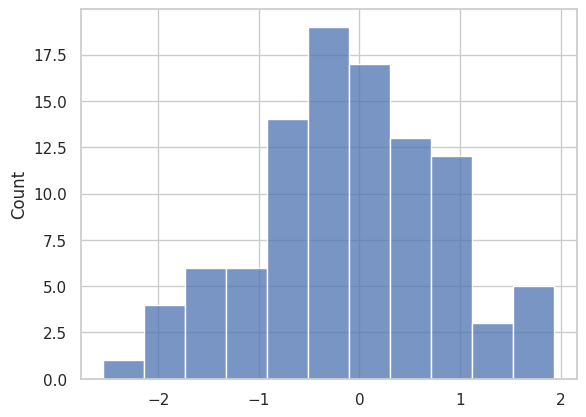

In [6]:
sns.histplot(feature_spaces[0][0])

split feature spaces into train and test samples

In [7]:
feature_spaces_train = [feature_space[:n_samples_train] for feature_space in feature_spaces]
feature_spaces_test = [feature_space[n_samples_train:] for feature_space in feature_spaces]

concatenate the first feature with all other feature spaces
[0, 1], [0, 2], [0, 3], ...

In [8]:
Xs_train = [np.hstack([feature_spaces_train[0], feature_space]) for feature_space in feature_spaces_train[1:]]
Xs_test = [np.hstack([feature_spaces_test[0], feature_space]) for feature_space in feature_spaces_test[1:]]

In [9]:
Xs_train = [zscore(x) for x in Xs_train]
Xs_test = [zscore(x) for x in Xs_test]

generate weights

In [10]:
betas = [np.random.randn(d, n_targets) for d in d_list]

In [11]:
betas = [zscore(beta) for beta in betas]

create targets

In [12]:
Y_train = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_train, betas)])
Y_test = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_test, betas)])

In [13]:
Y_train = zscore(Y_train)
Y_test = zscore(Y_test)

add noise

In [14]:
noise_train = zscore(np.random.randn(n_samples_train, n_targets))
noise_test = zscore(np.random.randn(n_samples_test, n_targets))

In [15]:
Y_train += noise_train * noise_scalar
Y_test += noise_test * noise_scalar

train simple linear models to confirm feature spaces predict the target

<Axes: >

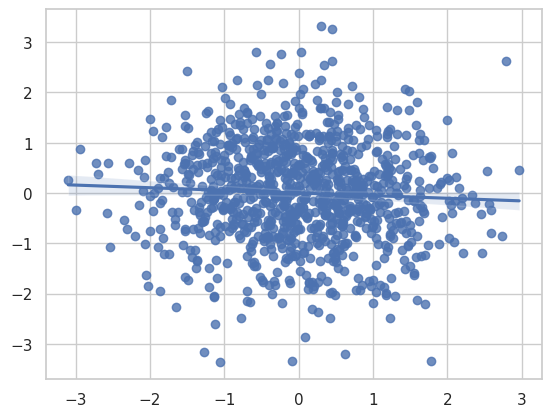

In [16]:
sns.regplot(x=Xs_train[0][:, 1], y=Y_train[:, 1])

In [17]:
scores = pd.DataFrame()

linear_models = [RidgeCV(alphas=alphas) for _ in range(len(feature_spaces_train))]
for i, model in enumerate(linear_models):
    model.fit(feature_spaces_train[i], Y_train)
    score = model.score(feature_spaces_test[i], Y_test)
    scores = pd.concat([
        scores,
        pd.DataFrame({'model': [i], 'Type': ['Score'], 'Values': [score.mean()]})], ignore_index=True
    )

CUDARuntimeError: cudaErrorUnknown: unknown error

In [ ]:
sns.catplot(scores, x="model", y="Values", kind="bar")
plt.ylim([-0.05, 1.05])

now train on researcher side feature spaces

In [ ]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV(alphas=alphas) for _ in range(len(Xs_train))]
for i, model in enumerate(linear_models):
    model.fit(Xs_train[i], Y_train)
    score = model.score(Xs_test[i], Y_test)
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'model': [i], 'Type': ['Score'], 'Values': [score.mean()]})], ignore_index=True
    )

In [ ]:
sns.catplot(researcher_scores, x="model", y="Values", kind="bar")
plt.ylim([-0.05, 1.05])